# Description

We will be using the "improved" vesion of the Schaefer/Yeo Atlas distributed with AFNI. We do this, becuase this modified version is aligned to the MNI 2009c template, wich is the one we used in afni_proc for spatial normalization.

* AFNI Poster describing this ATLAS and the issue is intended to resolve: (https://afni.nimh.nih.gov/pub/dist/HBM2021/Schaefer-Yeo_AFNI_Atlas_OHBM2021_Poster.pdf)
* Downloaded Atlas File: (https://afni.nimh.nih.gov/pub/dist/atlases/SchaeferYeo/schaefer_yeo_developer_build_1.0.tgz)


***

# 1. Check all final files are in the same grid

```bash
cd /data/SFIMJGC_HCP7T/BCBL2024/prcs_data
3dinfo -same_all_grid sub-*/D02_Preproc_fMRI_ses-?/errts.sub-*.fanaticor+tlrc.HEAD
```

This returned all 1s (so yes, all in same grid)

***

# 2. Create the Atlas Folder and Copy the Atlas there

```bash
cd /data/SFIMJGC_HCP7T/BCBL2024/
mkdir atlases
mkdir atlases/Schaefer2018_400Parcels_17Networks

cd atlases/Schaefer2018_400Parcels_17Networks
cd ../../downloads/

# Untar the file we downloaded from AFNI's website above
tar xzvf schaefer_yeo_developer_build_1.0.tgz

cd /data/SFIMJGC_HCP7T/BCBL2024/atlases/Schaefer2018_400Parcels_17Networks
cp ../../downloads/schaefer_yeo/afni_atlas/Schaefer_17N_400.nii.gz Schaefer2018_400Parcels_17Networks_AFNI.nii.gz

```
Also copy the following files from their original location in CBIG repo (link above) to your local Schaefer Atlas folder:

* [```Schaefer2018_400Parcels_17Networks_order.txt```](https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/freeview_lut/Schaefer2018_400Parcels_17Networks_order.txt): list of all ROI, their network membership and color code (RGB).
* [```Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2mm.Centroid_RAS.csv```](https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2mm.Centroid_RAS.csv): information about each ROI centroid coordinates.


***

# 3. Bring the Atlas to the same final grid as the EPI data

The downloaded atlas does not have the same dimensions as our final data. This can be seen running the following 3dinfo command
```bash
cd /data/SFIMJGC_HCP7T/BCBL2024/atlases/Schaefer2018_400Parcels_17Networks
3dinfo -same_all_grid -n4 -d3 -header_name -header_line ../../prcs_data/sub-01/D02_Preproc_fMRI_ses-1/errts.sub-01.fanaticor+tlrc.HEAD Schaefer2018_400Parcels_17Networks_AFNI.nii.gz
```

```=ornt?	=cent?	=obl?	sDval	Dval	Nj	Nk	Nt	Nvi	Dk	Di_Dj_Dk	Oi	all_nms
0	0	1	1	1	64	76	64	201	-3.000000	-3.000000	3.000000	../../prcs_data/sub-01/D02_Preproc_fMRI_ses-1/errts.sub-01.fanaticor+tlrc.HEAD
0	0	1	1	1	193	229	193	1	-1.000000	-1.000000	1.000000	./Schaefer2018_400Parcels_17Networks.nii.gz
```

To resolve that, we need to do the following:

```bash
@MakeLabelTable -lab_file Schaefer2018_400Parcels_17Networks_order.txt 1 0 \
                -labeltable Schaefer2018_400Parcels_17Networks.niml.lt 

3dresample -overwrite -inset Schaefer2018_400Parcels_17Networks_AFNI.nii.gz \
           -master ../../prcs_data/sub-01/D02_Preproc_fMRI_ses-1/errts.sub-01.fanaticor+tlrc.HEAD \
           -rmode NN \
           -prefix Schaefer2018_400Parcels_17Networks_AFNI.final_grid.nii.gz

3drefit -labeltable Schaefer2018_400Parcels_17Networks.niml.lt Schaefer2018_400Parcels_17Networks_AFNI.final_grid.nii.gz
```

In [7]:
import pandas as pd
from glob import glob
import os.path as osp
import subprocess
import datetime
import os
from utils.basics import PRCS_DATA_DIR, ATLASES_DIR, ATLAS_NAME, PRJ_DIR, CODE_DIR
ATLAS_DIR = osp.join(ATLASES_DIR,ATLAS_NAME)

In [3]:
import getpass
username = getpass.getuser()
print(username)

javiergc


In [2]:
dataset_info_df = pd.read_csv(osp.join(PRJ_DIR,'resources','good_scans.txt'))
dataset_info_df = dataset_info_df.set_index(['Subject','Session'])
print('++ Number of scans: %s scans' % dataset_info_df.shape[0])

++ Number of scans: 436 scans


***

# 4. Find FOV common to all selected scans


In [5]:
script_path = osp.join(PRJ_DIR,f'swarm.{username}','N02_check_sample_FOV_vs_atlas.swarm.sh')
print(script_path)

/data/SFIMJGC_HCP7T/BCBL2024/swarm.javiergc/N02_check_sample_FOV_vs_atlas.swarm.sh


In [8]:
log_path = osp.join(PRJ_DIR,f'logs.{username}','N02_check_sample_FOV_vs_atlas.log')
if not osp.exists(log_path):
    os.makedirs(log_path)
print(log_path)

/data/SFIMJGC_HCP7T/BCBL2024/logs.javiergc/N02_check_sample_FOV_vs_atlas.log


In [14]:
with open(script_path, 'w') as the_file:
    the_file.write('# Script Creation Date: %s\n' % str(datetime.date.today()))
    the_file.write(f'# swarm -f {script_path} -g 16 -t 8 -b 5 --time 00:20:00 --logdir {log_path} --partition quick,norm --module afni\n')
    the_file.write('\n')
    for sbj,ses in list(dataset_info_df.index):
        the_file.write(f'cd {PRCS_DATA_DIR}/{sbj}/D02_Preproc_fMRI_{ses}; 3dNetCorr -overwrite -in_rois {ATLASES_DIR}/{ATLAS_NAME}/{ATLAS_NAME}_AFNI.final_grid.nii.gz -output_mask_nonnull -inset pb04.{sbj}.r01.combine+tlrc.HEAD -prefix rm.{sbj}.combine.{ATLAS_NAME}.FOVcheck \n')
the_file.close()     

```bash
cd /data/SFIMJGC_HCP7T/BCBL2024/swarm.javiergc
swarm -f /data/SFIMJGC_HCP7T/BCBL2024/swarm.javiergc/N02_check_sample_FOV_vs_atlas.swarm.sh -g 16 -t 8 -b 5 --time 00:20:00 --logdir /data/SFIMJGC_HCP7T/BCBL2024/logs.javiergc/N02_check_sample_FOV_vs_atlas.log --partition quick,norm --module afni
```

In [15]:
for sbj,ses in list(dataset_info_df.index):
    expected_output_path = osp.join(PRCS_DATA_DIR,sbj,f'D02_Preproc_fMRI_{ses}',f'rm.{sbj}.combine.{ATLAS_NAME}.FOVcheck_mask_nnull+tlrc.HEAD')
    if not osp.exists(expected_output_path):
        print('++ WARNING: %s is missing' % expected_output_path)

***
# 5. Find Bad ROIs

In [16]:
bad_roi_list = []
for sbj,ses in list(dataset_info_df.index):
    roidat_path       = osp.join(PRCS_DATA_DIR,sbj,f'D02_Preproc_fMRI_{ses}',f'rm.{sbj}.combine.{ATLAS_NAME}.FOVcheck_000.roidat')
    roidat_df         = pd.read_csv(roidat_path,sep=' ', skipinitialspace=True, header=0)
    correct_columns   = roidat_df.columns.drop(['#'])
    roidat_df         = roidat_df.drop(['ROI_label'],axis=1)
    roidat_df.columns = correct_columns
    roidat_df         = roidat_df.drop(['#.1'],axis=1)
    bad_rois          = roidat_df[roidat_df['frac']<=0.1][['ROI','ROI_label']]
    if bad_rois.shape[0] > 8:
        print('++ INFO: %s/%s --> Number of Bad Rois: %d' % (sbj,ses,bad_rois.shape[0]), end=' | ')
    for i,br in bad_rois.iterrows():
        bad_roi_list.append((br['ROI'],br['ROI_label']))

++ INFO: sub-107/ses-1 --> Number of Bad Rois: 10 | ++ INFO: sub-107/ses-2 --> Number of Bad Rois: 9 | ++ INFO: sub-109/ses-1 --> Number of Bad Rois: 10 | ++ INFO: sub-109/ses-2 --> Number of Bad Rois: 9 | ++ INFO: sub-10/ses-1 --> Number of Bad Rois: 10 | ++ INFO: sub-114/ses-1 --> Number of Bad Rois: 10 | ++ INFO: sub-114/ses-2 --> Number of Bad Rois: 10 | ++ INFO: sub-11/ses-1 --> Number of Bad Rois: 10 | ++ INFO: sub-11/ses-2 --> Number of Bad Rois: 10 | ++ INFO: sub-124/ses-1 --> Number of Bad Rois: 9 | ++ INFO: sub-12/ses-2 --> Number of Bad Rois: 13 | ++ INFO: sub-134/ses-1 --> Number of Bad Rois: 10 | ++ INFO: sub-134/ses-2 --> Number of Bad Rois: 10 | ++ INFO: sub-136/ses-1 --> Number of Bad Rois: 13 | ++ INFO: sub-136/ses-2 --> Number of Bad Rois: 9 | ++ INFO: sub-142/ses-1 --> Number of Bad Rois: 10 | ++ INFO: sub-145/ses-1 --> Number of Bad Rois: 11 | ++ INFO: sub-145/ses-2 --> Number of Bad Rois: 11 | ++ INFO: sub-14/ses-1 --> Number of Bad Rois: 12 | ++ INFO: sub-14/ses-2

In [17]:
bad_roi_list = list(set(bad_roi_list))

In [18]:
print(bad_roi_list)

[(192, '17Networks_LH_DefaultC_PHC_1'), (134, '17Networks_LH_ContB_Temp_1'), (389, '17Networks_RH_DefaultC_PHC_1'), (319, '17Networks_RH_LimbicA_TempPole_1'), (358, '17Networks_RH_DefaultA_Temp_1'), (112, '17Networks_LH_LimbicB_OFC_4'), (109, '17Networks_LH_LimbicB_OFC_1'), (116, '17Networks_LH_LimbicA_TempPole_3'), (110, '17Networks_LH_LimbicB_OFC_2'), (169, '17Networks_LH_DefaultB_Temp_3'), (111, '17Networks_LH_LimbicB_OFC_3'), (60, '17Networks_LH_DorsAttnA_TempOcc_1'), (316, '17Networks_RH_LimbicB_OFC_4'), (322, '17Networks_RH_LimbicA_TempPole_4'), (336, '17Networks_RH_ContB_Temp_1'), (324, '17Networks_RH_LimbicA_TempPole_6'), (118, '17Networks_LH_LimbicA_TempPole_5'), (347, '17Networks_RH_ContB_PFClv_2'), (313, '17Networks_RH_LimbicB_OFC_1'), (317, '17Networks_RH_LimbicB_OFC_5'), (168, '17Networks_LH_DefaultB_Temp_2'), (114, '17Networks_LH_LimbicA_TempPole_1'), (117, '17Networks_LH_LimbicA_TempPole_4'), (115, '17Networks_LH_LimbicA_TempPole_2'), (320, '17Networks_RH_LimbicA_TempPol

In [19]:
print('++ INFO: Number of ROIs to remove = %d ROIs' % len(bad_roi_list))

++ INFO: Number of ROIs to remove = 29 ROIs


***
# 6. Remove Bad ROIs from ATLAS

In [20]:
bad_rois_minus = '-'.join([str(r)+'*equals(a,'+str(r)+')' for r,rs in bad_roi_list])
bad_rois_plus  = '+'.join([str(r)+'*equals(a,'+str(r)+')' for r,rs in bad_roi_list])
print(bad_rois_minus)
print(bad_rois_plus)

192*equals(a,192)-134*equals(a,134)-389*equals(a,389)-319*equals(a,319)-358*equals(a,358)-112*equals(a,112)-109*equals(a,109)-116*equals(a,116)-110*equals(a,110)-169*equals(a,169)-111*equals(a,111)-60*equals(a,60)-316*equals(a,316)-322*equals(a,322)-336*equals(a,336)-324*equals(a,324)-118*equals(a,118)-347*equals(a,347)-313*equals(a,313)-317*equals(a,317)-168*equals(a,168)-114*equals(a,114)-117*equals(a,117)-115*equals(a,115)-320*equals(a,320)-321*equals(a,321)-315*equals(a,315)-113*equals(a,113)-318*equals(a,318)
192*equals(a,192)+134*equals(a,134)+389*equals(a,389)+319*equals(a,319)+358*equals(a,358)+112*equals(a,112)+109*equals(a,109)+116*equals(a,116)+110*equals(a,110)+169*equals(a,169)+111*equals(a,111)+60*equals(a,60)+316*equals(a,316)+322*equals(a,322)+336*equals(a,336)+324*equals(a,324)+118*equals(a,118)+347*equals(a,347)+313*equals(a,313)+317*equals(a,317)+168*equals(a,168)+114*equals(a,114)+117*equals(a,117)+115*equals(a,115)+320*equals(a,320)+321*equals(a,321)+315*equals(a,3

In [21]:
command=f"""module load afni; \
           cd {ATLAS_DIR}; \
           3dcalc -overwrite \
                  -a {ATLAS_NAME}_AFNI.final_grid.nii.gz \
                  -expr '{bad_rois_plus}' \
                  -prefix {ATLAS_NAME}_AFNI.final_grid.RemovedROIs.nii.gz; \
           3dcalc -overwrite \
                  -a      {ATLAS_NAME}_AFNI.final_grid.nii.gz \
                  -expr 'a-{bad_rois_minus}' \
                  -prefix rm.{ATLAS_NAME}_AFNI.final_grid.fov_restricted.nii.gz; \
           3drefit -labeltable {ATLAS_NAME}.niml.lt rm.{ATLAS_NAME}_AFNI.final_grid.fov_restricted.nii.gz"""
output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-08-16

++ 3dcalc: AFNI version=AFNI_24.2.01 (Jul 16 2024) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset ./Schaefer2018_400Parcels_17Networks_AFNI.final_grid.RemovedROIs.nii.gz
++ 3dcalc: AFNI version=AFNI_24.2.01 (Jul 16 2024) [64-bit]
++ Authored by: A cast of thousands
++ Output dataset ./rm.Schaefer2018_400Parcels_17Networks_AFNI.final_grid.fov_restricted.nii.gz
++ 3drefit: AFNI version=AFNI_24.2.01 (Jul 16 2024) [64-bit]
++ Authored by: RW Cox
++ Processing AFNI dataset rm.Schaefer2018_400Parcels_17Networks_AFNI.final_grid.fov_restricted.nii.gz
 + setting labeltable
 + loading and re-writing dataset rm.Schaefer2018_400Parcels_17Networks_AFNI.final_grid.fov_restricted.nii.gz (/vf/users/SFIMJGC_HCP7T/BCBL2024/atlases/Schaefer2018_400Parcels_17Networks/rm.Schaefer2018_400Parcels_17Networks_AFNI.final_grid.fov_restricted.nii.gz in NIFTI storage)
++ 3drefit processed 1 datasets


In [22]:
from nilearn.plotting import plot_roi

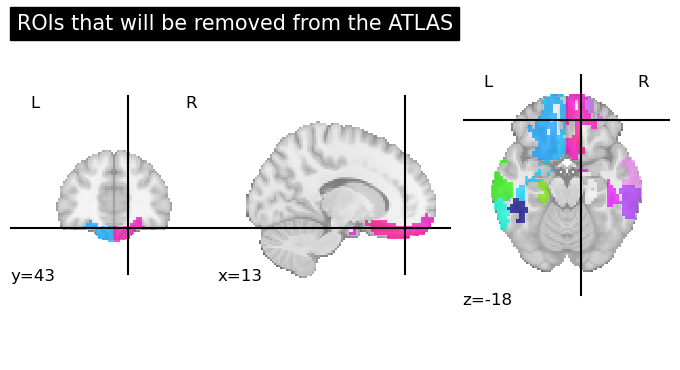

In [23]:
plot_roi(osp.join(ATLAS_DIR,f'{ATLAS_NAME}_AFNI.final_grid.RemovedROIs.nii.gz'),title='ROIs that will be removed from the ATLAS')

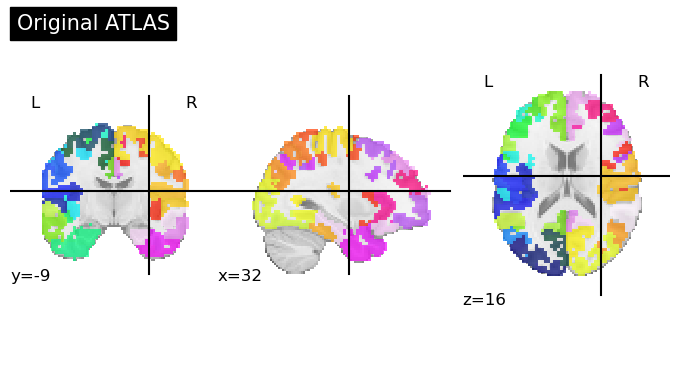

In [24]:
plot_roi(osp.join(ATLAS_DIR,f'{ATLAS_NAME}_AFNI.final_grid.nii.gz'),title='Original ATLAS')

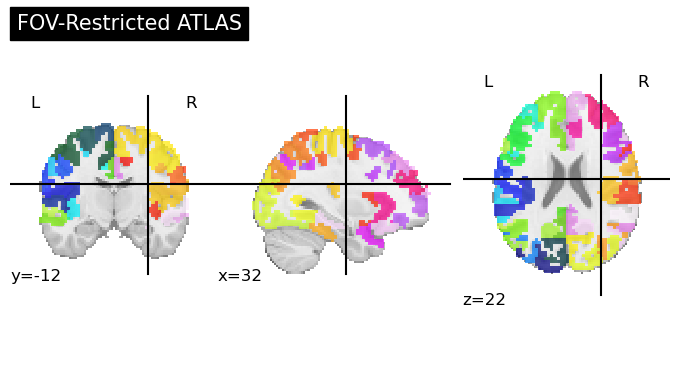

In [25]:
plot_roi(osp.join(ATLAS_DIR,f'rm.{ATLAS_NAME}_AFNI.final_grid.fov_restricted.nii.gz'),title='FOV-Restricted ATLAS')

***
# 7. Rank the FOV-restricted Atlas

In [26]:
command = f"""ml afni; \
             cd {ATLAS_DIR}; \
             3dRank -prefix rm.{ATLAS_NAME}_AFNI.final_grid.fov_restricted.ranked.nii.gz -input rm.{ATLAS_NAME}_AFNI.final_grid.fov_restricted.nii.gz;"""
output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-08-16

++ Output dataset /vf/users/SFIMJGC_HCP7T/BCBL2024/atlases/Schaefer2018_400Parcels_17Networks/rm.Schaefer2018_400Parcels_17Networks_AFNI.final_grid.fov_restricted.ranked.nii.gz


***
# 8. Create rank corrected Order & Centroid Files

In [27]:
from sfim_lib.atlases.raking import correct_ranked_atlas

In [28]:
path_to_order_file     = osp.join(ATLAS_DIR,f'{ATLAS_NAME}_order.txt')
path_to_rank_file      = osp.join(ATLAS_DIR,f'rm.{ATLAS_NAME}_AFNI.final_grid.fov_restricted.ranked.nii.gz.rankmap.1D')
path_to_centroids_file = osp.join(ATLAS_DIR,f'{ATLAS_NAME}_order_FSLMNI152_2mm.Centroid_RAS.csv')
correct_ranked_atlas(path_to_order_file,path_to_centroids_file,path_to_rank_file)

++ INFO [correct_ranked_shaefer_atlas] Original Order File in memory [(400, 5)]
++ INFO [correct_ranked_shaefer_atlas] Original Centroids File in memory [(400, 4)]
++ INFO [correct_ranked_shaefer_atlas] Rank information in memory    [(372, 2)]
++ INFO [correct_ranked_shaefer_atlas] New order file written to disk: /data/SFIMJGC_HCP7T/BCBL2024/atlases/Schaefer2018_400Parcels_17Networks/Schaefer2018_400Parcels_17Networks_order.ranked.txt
++ INFO [correct_ranked_shaefer_atlas] New centroids file written to disk: /data/SFIMJGC_HCP7T/BCBL2024/atlases/Schaefer2018_400Parcels_17Networks/Schaefer2018_400Parcels_17Networks.Centroid_RAS.ranked.csv
 + Original Number of ROIs = 400
 + New      Number of ROIs = 371
 + Last entry in original Order File:
ID      17Networks_RH_TempPar_10
R                             13
G                             42
B                            247
Size                           0
Name: 400, dtype: object
 + Last entry in new Order File:
Number                      

***
# 9. Add corrected label table to the ranked version of the atlas

In [29]:
command = f"""module load afni; \
             cd {ATLAS_DIR}; \
             @MakeLabelTable -lab_file {ATLAS_NAME}_order.ranked.txt 1 0 -labeltable {ATLAS_NAME}_order.ranked.niml.lt -dset rm.{ATLAS_NAME}_AFNI.final_grid.fov_restricted.ranked.nii.gz;"""
output  = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
print(output.strip().decode())

[+] Loading AFNI current-py3  ... 
AFNI/current-py3 last updated  2024-08-16

++ 3drefit: AFNI version=AFNI_24.2.01 (Jul 16 2024) [64-bit]
++ Authored by: RW Cox
++ Processing AFNI dataset rm.Schaefer2018_400Parcels_17Networks_AFNI.final_grid.fov_restricted.ranked.nii.gz
 + setting labeltable
 + loading and re-writing dataset rm.Schaefer2018_400Parcels_17Networks_AFNI.final_grid.fov_restricted.ranked.nii.gz (/vf/users/SFIMJGC_HCP7T/BCBL2024/atlases/Schaefer2018_400Parcels_17Networks/rm.Schaefer2018_400Parcels_17Networks_AFNI.final_grid.fov_restricted.ranked.nii.gz in NIFTI storage)
++ 3drefit processed 1 datasets


***
# 10. Create a Dataframe with all the necessary info about the final FOV-restricted Atlas

In [30]:
def rgb2hex(r,g,b):
    """
    Converts between two different versions of RGB color codes. Input as three separate integers between 0 and 256.
    Output will be in hexadecimal code.
    """
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

In [31]:
# Load the cetroid file for the ranked atlas in memory
centroids_info               = pd.read_csv(osp.join(ATLAS_DIR,f'{ATLAS_NAME}.Centroid_RAS.ranked.csv' ))
centroids_info['ROI Name']   = [label.split('7Networks_')[1] for label in centroids_info['ROI Name']]
centroids_info['Hemisphere'] = [item.split('_')[0] for item in centroids_info['ROI Name']]
centroids_info['Network']    = [item.split('_')[1] for item in centroids_info['ROI Name']]
# Load the color info file for the ranked atlas in memory
color_info = pd.read_csv(osp.join(ATLAS_DIR, f'{ATLAS_NAME}_order.ranked.txt'),sep='\t', header=None)
# Combine all the useful columns into a single new dataframe
df         = pd.concat([centroids_info[['ROI Label','Hemisphere','Network','ROI Name','R','A','S']],color_info[[2,3,4]]], axis=1)
df.columns = ['ROI_ID','Hemisphere','Network','ROI_Name','pos_R','pos_A','pos_S','color_R','color_G','color_B']
df['RGB']  = [rgb2hex(r,g,b) for r,g,b in df.set_index('ROI_ID')[['color_R','color_G','color_B']].values]
# Save the new data frame to disk
df.to_csv(osp.join(ATLAS_DIR,f'{ATLAS_NAME}.roi_info.csv'), index=False)

In [32]:
df

,ROI_ID,Hemisphere,Network,ROI_Name,pos_R,pos_A,pos_S,color_R,color_G,color_B,RGB
0,1,LH,VisCent,LH_VisCent_ExStr_1,-36,-62,-16,120,18,131,#781283
1,2,LH,VisCent,LH_VisCent_ExStr_2,-24,-72,-10,120,18,132,#781284
2,3,LH,VisCent,LH_VisCent_ExStr_3,-36,-82,-16,120,18,133,#781285
3,4,LH,VisCent,LH_VisCent_ExStr_4,-16,-86,-16,120,18,134,#781286
4,5,LH,VisCent,LH_VisCent_ExStr_5,-24,-96,-12,120,18,136,#781288
...,...,...,...,...,...,...,...,...,...,...,...
366,367,RH,TempPar,RH_TempPar_6,60,-46,6,13,41,251,#0d29fb
367,368,RH,TempPar,RH_TempPar_7,52,-40,12,13,41,252,#0d29fc
368,369,RH,TempPar,RH_TempPar_8,64,-34,10,13,41,253,#0d29fd
369,370,RH,TempPar,RH_TempPar_9,54,-46,20,13,41,254,#0d29fe


***
# 11. Clean-up atlas directory

```bash
cd /data/SFIMJGC_HCP7T/BCBL2024/atlases/Schaefer2018_400Parcels_17Networks

mkdir orig
mv Schaefer2018_400Parcels_17Networks_AFNI.nii.gz orig
mv Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2mm.Centroid_RAS.csv orig
mv Schaefer2018_400Parcels_17Networks_order.txt orig

mkdir final_grid
mv Schaefer2018_400Parcels_17Networks_AFNI.final_grid.nii.gz final_grid
mv Schaefer2018_400Parcels_17Networks_AFNI.final_grid.RemovedROIs.nii.gz final_grid
mv rm.Schaefer2018_400Parcels_17Networks_AFNI.final_grid.fov_restricted.nii.gz final_grid

mv rm.Schaefer2018_400Parcels_17Networks_AFNI.final_grid.fov_restricted.ranked.nii.gz Schaefer2018_400Parcels_17Networks.nii.gz
mv Schaefer2018_400Parcels_17Networks_order.ranked.niml.lt Schaefer2018_400Parcels_17Networks.niml.lt
mv Schaefer2018_400Parcels_17Networks.Centroid_RAS.ranked.csv Schaefer2018_400Parcels_17Networks.csv
mv Schaefer2018_400Parcels_17Networks_order.ranked.txt Schaefer2018_400Parcels_17Networks_order.txt
mv rm.Schaefer2018_400Parcels_17Networks_AFNI.final_grid.fov_restricted.ranked.nii.gz.rankmap.1D Schaefer2018_400Parcels_17Networks.rankmap.1D
```

***
# 12. Create a binary mask of the atlas

This will come handy for using nilearn unmask functions later

```bash
cd /data/SFIMJGC_HCP7T/BCBL2024/atlases/Schaefer2018_400Parcels_17Networks
3dcalc -overwrite -a Schaefer2018_400Parcels_17Networks.nii.gz -expr 'step(a)' -prefix Schaefer2018_400Parcels_17Networks.mask.nii.gz
```